1/10, loss=0.0296, accuracy=0.8241
2/10, loss=0.0140, accuracy=0.9118
3/10, loss=0.0120, accuracy=0.9240
4/10, loss=0.0107, accuracy=0.9326
5/10, loss=0.0098, accuracy=0.9385
6/10, loss=0.0090, accuracy=0.9434
7/10, loss=0.0083, accuracy=0.9483
8/10, loss=0.0077, accuracy=0.9524
9/10, loss=0.0071, accuracy=0.9562
10/10, loss=0.0067, accuracy=0.9594


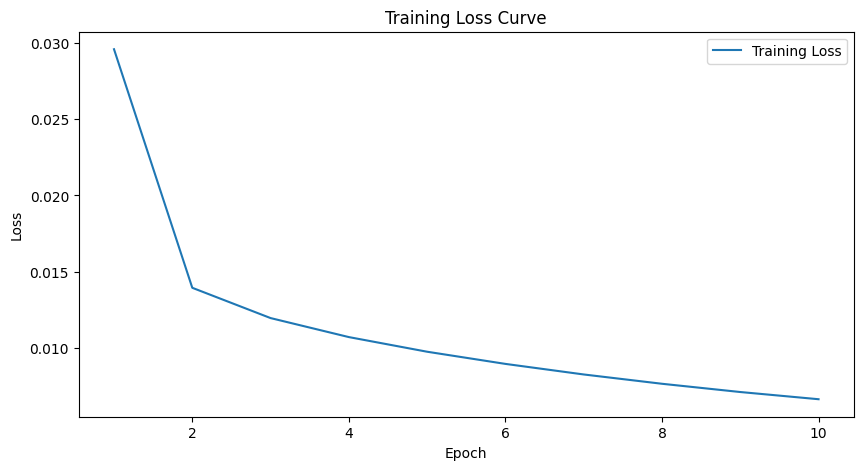

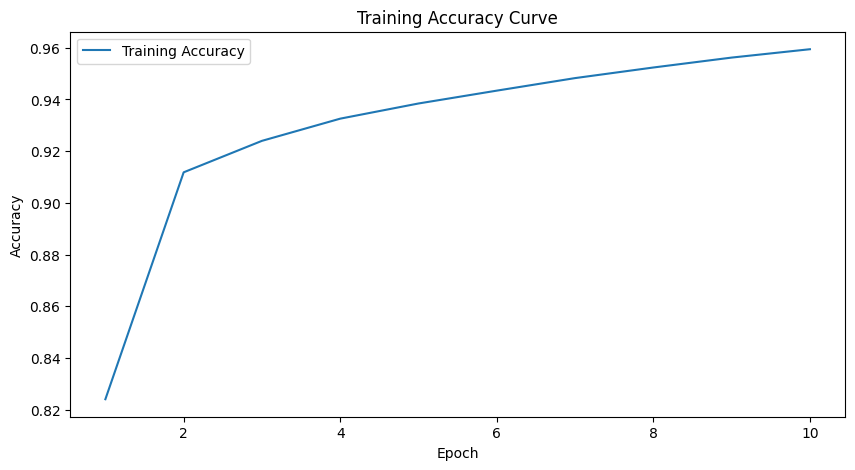

In [14]:
import numpy as np 
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the neural network architecture
network = [
    FlattenLayer(input_shape=(28, 28)),
    FCLayer(28 * 28, 128),
    ActivationLayer(relu, relu_prime),
    FCLayer(128, 10),
    SoftmaxLayer(10)
]

# Training parameters
epochs = 10
learning_rate = 0.01

# Lists to store loss and accuracy values
train_loss = []
train_accuracy = []

# Training loop
for epoch in range(epochs):
    error = 0
    correct = 0
    total = 0
    for x, y_true in zip(x_train, y_train):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate loss
        error += mse(y_true, output)
        
        # Calculate accuracy
        if np.argmax(output) == np.argmax(y_true):
            correct += 1
        total += 1
        
        # Backward pass
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)
    
    # Calculate average loss and accuracy for the epoch
    error /= len(x_train)
    accuracy = correct / total
    
    # Store loss and accuracy values
    train_loss.append(error)
    train_accuracy.append(accuracy)
    
    # Print progress
    print('%d/%d, loss=%.4f, accuracy=%.4f' % (epoch + 1, epochs, error, accuracy))

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()
